In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, ConcatDataset, TensorDataset, DataLoader, Dataset, Subset
from matplotlib import animation
import os
import wandb
import h5py
from pathlib import Path

print("PyTorch Version: ",torch.__version__)
print("Cuda available: ",torch.cuda.is_available())
print("Cuda Version: ",torch.version.cuda)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#from dataloaders.SimpleLoaderBubbleML import *
from modelComp.UNet import *
from trainers.simpletrainer import one_epoch_train_simple, one_epoch_val_simple
from dataloaders.SimpleLoaderBubbleML import *

PyTorch Version:  2.4.1+cu121
Cuda available:  True
Cuda Version:  12.1


In [2]:
twall_100 = h5py.File('C:/Users/tphar/Documents/2024-II/AutoregressiveNeuralOperators/data/PoolBoiling-SubCooled-FC72-2D/Twall-100.hdf5', 'r')

# Print all keys in the file
print("Keys in the HDF5 file:")
for key in twall_100.keys():
    print(key)

# Access one specific dataset for further processing
real_runtime_params = twall_100['real-runtime-params'][:]
key0, val0 = real_runtime_params[0]
int_runtime_params = twall_100['int-runtime-params'][:]
key1, val1 = real_runtime_params[0]

print(f'\nMetadata size: {real_runtime_params.shape}')
print(f'Key type: {type(key0)}')
print(f'Val type: {type(val0)}')

def key_to_str(key):
    # Convert byte string to a standard python utf-8 string.
    return key.decode('utf-8').strip()

# Convert to a dict of (string, float64)
runtime_param_dict = dict([(key_to_str(key), val) for (key, val) in real_runtime_params])
int_param_dict = dict([(key_to_str(key), val) for (key, val) in int_runtime_params])

# Print the Reynolds number
inv_reynolds = runtime_param_dict['ins_invreynolds']
print(f'\nReynolds Number: {1 / inv_reynolds}')
print()
for key, val in runtime_param_dict.items():
    print(f'{key}: {val}')

print()

for key, val in int_param_dict.items():
    print(f'{key}: {val}')

Keys in the HDF5 file:
dfun
int-runtime-params
pressure
real-runtime-params
temperature
velx
vely
x
y

Metadata size: (109,)
Key type: <class 'numpy.bytes_'>
Val type: <class 'numpy.float64'>

Reynolds Number: 238.0952380952381

checkpointfileintervaltime: 5.0
checkpointfileintervalz: 1.7976931348623157e+308
derefine_cutoff_1: 0.2
derefine_cutoff_2: 0.2
derefine_cutoff_3: 0.2
derefine_cutoff_4: 0.2
dr_dtmincontinue: 0.0
dr_tstepslowstartfactor: 0.1
dtinit: 0.0001
dtmax: 0.0004
dtmin: 1e-10
gr_amrexmg_tol: 1e-13
gr_btworkchildscaling: 1.0
gr_btworkdefaultleaf: 2.0
gr_btworkdefaultpar: 1.0
gr_btworklbleaf: 0.0
gr_btworklbpar: 0.0
gr_btworkubleaf: 1000000.0
gr_btworkubpar: 1000000.0
gr_lrefinemaxredlogbase: 10.0
gr_lrefinemaxredradiusfact: 0.0
gr_lrefinemaxredtref: 0.0
gr_lrefinemaxredtimescale: 1.0
gr_lrefmaxtime_1: -1.0
gr_lrefmaxtime_10: -1.0
gr_lrefmaxtime_11: -1.0
gr_lrefmaxtime_12: -1.0
gr_lrefmaxtime_13: -1.0
gr_lrefmaxtime_14: -1.0
gr_lrefmaxtime_15: -1.0
gr_lrefmaxtime_16: -1.0
g

In [3]:
dataPath = 'C:/Users/tphar/Documents/2024-II/AutoregressiveNeuralOperators/data/PoolBoiling-SubCooled-FC72-2D/'
downsampled = True

dataPath = dataPath + 'downsampled_redimensionalized/' if downsampled else dataPath
train_files = ['Twall-95.hdf5', 'Twall-98.hdf5', 'Twall-103.hdf5', 'Twall-106.hdf5']
train_files = [dataPath + file for file in train_files]

val_files = ['Twall-100.hdf5']
val_files = [dataPath + file for file in val_files]

train_dataset = ConcatDataset(SimpleLoaderBubbleML(file) for file in train_files)
fullstack_train = SimpleLoaderBubbleML(train_files[1])
val_dataset = ConcatDataset(SimpleLoaderBubbleML(file) for file in val_files)
fullstack_val = SimpleLoaderBubbleML(val_files[0])
#dataset = SimpleLoaderBubbleML(files[0])

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# take first 60% of the data for training, do not shuffle and take last 20% for validation

#total_size = len(dataset)
#train_size = int(0.8 * len(dataset))
#val_size = len(dataset) - train_size


#train_indices, val_indices = random_split(range(total_size), [train_size, val_size])


# Create Subset datasets to keep indices for mapping back to the original data
#train_dataset = Subset(dataset, train_indices.indices)
#val_dataset = Subset(dataset, val_indices.indices)







print(f'Train batches: {len(train_dataloader)}')
print(f'Val batches: {len(val_dataloader)}')

Train batches: 100
Val batches: 25


torch.Size([8, 3, 96, 96]) torch.Size([8, 3, 96, 96])


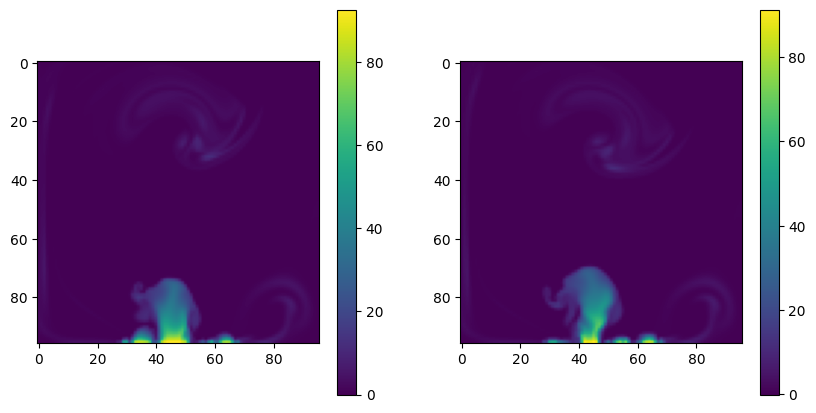

In [4]:
for batch_idx, (data, target) in enumerate(train_dataloader):
    print(data.shape, target.shape)
    break

# plot the temperature field
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
flipped_data = np.flipud(data[0, 0].numpy())
flipped_target = np.flipud(target[0, 0].numpy())
im0 = ax[0].imshow(flipped_data)
im1 = ax[1].imshow(flipped_target)
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])


plt.show()

In [7]:
newmodel = False
if newmodel:
    model = UNet2D(3, 3, features=(64, 128, 256)).to(DEVICE)
else:
    model = UNet2D(3, 3, features=(64, 128, 256)).to(DEVICE)
    model = model.load_state_dict(torch.load('../models/unet_model_BubbleML.pth'))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = UNet2D(3, 3, features=(64, 128, 256)).to(DEVICE)
print(f'The model has {count_parameters(model):,} trainable parameters')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

The model has 7,703,107 trainable parameters


C:\Users\tphar\AppData\Local\Temp\ipykernel_3648\2143172190.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = model.load_state_dict(torch.load('../models/unet_mode

In [8]:
EPOCHS = 1
wandb_on = False

if wandb_on:
    wandb.init(project="BubbleML_Unet", config={
        "epochs": EPOCHS
    })

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    avg_train_loss = one_epoch_train_simple(model, train_dataloader, optimizer, DEVICE)
    train_losses.append(avg_train_loss)

    avg_val_loss = one_epoch_val_simple(model, val_dataloader, DEVICE)
    val_losses.append(avg_val_loss)
    
    if wandb_on:
        wandb.log({
                "epoch": epoch + 1,
                "train_loss": avg_train_loss,
                "val_loss": avg_val_loss,
            })

    print(f"Epoch {epoch + 1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
if wandb_on:
    wandb.finish()  

Epoch 1/1 - Train Loss: 14.9893, Validation Loss: 14.0074


In [ ]:
model.eval()

dataFull = fullstack_train.get_full_stack()
start_index = 20
input = dataFull[start_index].to(DEVICE).float()
input = input.unsqueeze(0)
timesteps = 40
predictions = []
predictions.append(input.cpu())

with torch.no_grad():
    for t in range(timesteps - 1):
        pred = model(input) 
        predictions.append(pred.cpu())
        input = pred  

stacked_predictions = torch.stack(predictions, dim=0)
stacked_predictions = stacked_predictions.squeeze(1)

min_val = min(stacked_predictions.min(), dataFull.min())
max_val = max(stacked_predictions.max(), dataFull.max())
dataFull = (dataFull - min_val) / (max_val - min_val)
stacked_predictions = (stacked_predictions - min_val) / (max_val - min_val)

fig, ax = plt.subplots(2,1, figsize=(5, 10))

def update_frame(i):
    print(i, end='\r')
    ax[0].clear()
    ax[1].clear()
    imgpred = np.flipud(stacked_predictions[i, 0, :, :].numpy())
    imgtrue = np.flipud(dataFull[i + start_index, 0, :, :].numpy()) 
    ax[0].imshow(imgtrue, cmap='jet', vmin=0, vmax=1)
    ax[0].set_title("True")
    ax[1].imshow(imgpred, cmap='jet', vmin=0, vmax=1)
    ax[1].set_title("Prediction")
    fig.suptitle(f"Step {i + 1}/{timesteps}")
    ax[0].axis('off')
    ax[1].axis('off')
    

ani = animation.FuncAnimation(fig, update_frame, frames=timesteps, interval=500)

ani.save('../output/trainUNet.gif', writer='ffmpeg', fps=10)
# dont show the plot
plt.close()




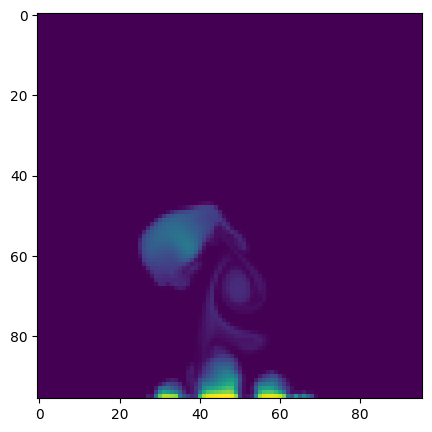

In [ ]:
model.eval()

dataFull = fullstack_val.get_full_stack()
start_index = 20
input = dataFull[start_index].to(DEVICE).float()
input = input.unsqueeze(0)
timesteps = 40
predictions = []
predictions.append(input.cpu())

with torch.no_grad():
    for t in range(timesteps - 1):
        pred = model(input) 
        predictions.append(pred.cpu())
        input = pred  

stacked_predictions = torch.stack(predictions, dim=0)
stacked_predictions = stacked_predictions.squeeze(1)

min_val = min(stacked_predictions.min(), dataFull.min())
max_val = max(stacked_predictions.max(), dataFull.max())
dataFull = (dataFull - min_val) / (max_val - min_val)
stacked_predictions = (stacked_predictions - min_val) / (max_val - min_val)


fig, ax = plt.subplots(2,1, figsize=(5, 10))

def update_frame(i):
    print(i, end='\r')
    ax[0].clear()
    ax[1].clear()
    imgpred = np.flipud(stacked_predictions[i, 0, :, :].numpy())
    imgtrue = np.flipud(dataFull[i + start_index, 0, :, :].numpy()) 
    ax[0].imshow(imgtrue, cmap='jet', vmin=0, vmax=1)
    ax[0].set_title("True")
    ax[1].imshow(imgpred, cmap='jet', vmin=0, vmax=1)
    ax[1].set_title("Prediction")
    fig.suptitle(f"Step {i + 1}/{timesteps}")
    ax[0].axis('off')
    ax[1].axis('off')
    
ani = animation.FuncAnimation(fig, update_frame, frames=timesteps, interval=500)

ani.save('../output/valUNet.gif', writer='ffmpeg', fps=10)
# dont show the plot
plt.close()

# plot the temperature field
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
input = predictions[0]
flipped_data = np.flipud(input[0,0,:,:].cpu().numpy())
ax.imshow(flipped_data)

In [12]:
def rollout_model(model, data, device, start_index, timesteps):
    model.eval()

    input = data[start_index].to(device).float().unsqueeze(0)
    predictions = [input.cpu()]

    with torch.no_grad():
        for _ in range(timesteps - 1):
            pred = model(input)
            predictions.append(pred.cpu())
            input = pred

    stacked_predictions = torch.stack(predictions, dim=0).squeeze(1)

    min_val = min(stacked_predictions.min(), data.min())
    max_val = max(stacked_predictions.max(), data.max())
    predictions_normalized = (stacked_predictions - min_val) / (max_val - min_val)

    return predictions_normalized

rollout_val = rollout_model(model, fullstack_val.get_full_stack(), DEVICE, 20, 40)
rollout_val.shape

torch.Size([40, 3, 96, 96])

In [14]:
def create_gif(true_data, predictions, start_index, timesteps, output_path, vertical=False):
    if vertical:
        fig, ax = plt.subplots(2, 1, figsize=(5, 10))
    else:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    def update_frame(i):
        ax[0].clear()
        ax[1].clear()

        imgtrue = np.flipud(true_data[i + start_index, 0, :, :].numpy())
        imgpred = np.flipud(predictions[i, 0, :, :].numpy())

        ax[0].imshow(imgtrue, cmap='jet', vmin=0, vmax=1)
        ax[0].set_title("True")
        ax[0].axis('off')

        ax[1].imshow(imgpred, cmap='jet', vmin=0, vmax=1)
        ax[1].set_title("Prediction")
        ax[1].axis('off')

        fig.suptitle(f"Step {i + 1}/{timesteps}")

    ani = animation.FuncAnimation(fig, update_frame, frames=timesteps, interval=500)
    ani.save(output_path, writer='ffmpeg', fps=10)
    plt.close()
heatertemp = 100
fullstack_val_norm = fullstack_val.get_full_stack() / heatertemp
create_gif(fullstack_val_norm, rollout_val, 20, 40, '../output/valUNet.gif', vertical=True)
fullstack_train_norm = fullstack_train.get_full_stack() / heatertemp
rollout_train = rollout_model(model, fullstack_train.get_full_stack(), DEVICE, 20, 40)
create_gif(fullstack_train_norm, rollout_train, 20, 40, '../output/trainUNet.gif', vertical=True)

In [20]:
# save model
#torch.save(model.state_dict(), '../models/unet_model_BubbleML.pth')

In [47]:
class FullLoaderBubbleML:
    def __init__(self, filename):
        self.filename = filename
        self.data = h5py.File(self.filename, 'r')
        self.timesteps = self.data[TEMPERATURE][:].shape[0]
        self.spatial_dims = self.data[TEMPERATURE][:].shape[1:]  # Get spatial dimensions (Y, X)
    
    def get_full_stack(self):
        """
        Retrieve the full temporal domain stack for the entire file.
        Returns a tensor with shape: [timesteps, channels, Y, X].
        """
        # Load temperature, velx, vely, and pressure data from the HDF5 file
        temp_data = torch.from_numpy(self.data[TEMPERATURE][:])  # Shape: [timesteps, Y, X]
        velx_data = torch.from_numpy(self.data[VELX][:])         # Shape: [timesteps, Y, X]
        vely_data = torch.from_numpy(self.data[VELY][:])         # Shape: [timesteps, Y, X]
        pres_data = torch.from_numpy(self.data[PRESSURE][:])     # Shape: [timesteps, Y, X]
        
        # Stack the data along the channel dimension
        full_stack = torch.stack((temp_data, velx_data, vely_data, pres_data), dim=1)  # Shape: [timesteps, channels, Y, X]
        return full_stack
    
    def get_metadata(self):
        """
        Retrieve metadata information such as the number of timesteps and spatial dimensions.
        """
        return {
            "timesteps": self.timesteps,
            "spatial_dims": self.spatial_dims
        }
    
# Initialize the loader
filename = files[0]
loader = FullLoaderBubbleML(filename)

# Get the full stack
full_stack = loader.get_full_stack()
print(f"Full stack shape: {full_stack.shape}")  # Expected: [timesteps, channels, Y, X]

# Access metadata
metadata = loader.get_metadata()
print(f"Number of timesteps: {metadata['timesteps']}")
print(f"Spatial dimensions: {metadata['spatial_dims']}")

Full stack shape: torch.Size([201, 4, 384, 384])
Number of timesteps: 201
Spatial dimensions: (384, 384)


In [ ]:
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class AutoregressiveModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(AutoregressiveModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out)

def train_autoregressive(model, dataloader, optimizer, loss_fn, max_rollout_steps):
    model.train()
    for batch in dataloader:
        inputs, targets = batch  # inputs: [batch_size, sequence_length, input_dim], targets: [batch_size, sequence_length, target_dim]
        batch_size, sequence_length, _ = inputs.size()

        optimizer.zero_grad()

        predictions = []
        current_input = inputs[:, 0:1]  # Start with the first timestep
        for t in range(max_rollout_steps):
            output = model(current_input)  # Predict the next timestep
            predictions.append(output)
            current_input = output  # Feed the prediction as the next input

        # Stack all predictions along the time dimension
        predictions = torch.cat(predictions, dim=1)  # [batch_size, max_rollout_steps, target_dim]

        # Compute loss only on the final prediction
        loss = loss_fn(predictions[:, -1], targets[:, max_rollout_steps - 1])

        loss.backward()
        optimizer.step()

        print(f"Loss: {loss.item()}")

# Example Usage
if __name__ == "__main__":
    # Dummy dataset
    class DummyDataset(torch.utils.data.Dataset):
        def __init__(self, num_samples, sequence_length, input_dim):
            self.data = torch.randn(num_samples, sequence_length, input_dim)
            self.targets = torch.randn(num_samples, sequence_length, input_dim)

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return self.data[idx], self.targets[idx]

    dataset = DummyDataset(num_samples=100, sequence_length=10, input_dim=3)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    # Model, optimizer, loss function
    model = AutoregressiveModel(input_size=3, hidden_size=16, output_size=3)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # Train
    train_autoregressive(model, dataloader, optimizer, loss_fn, max_rollout_steps=5)


"""